# Initial data preprocessing and model fitting

#### 0. Visualisation

Correlation matrix:

<AxesSubplot:>

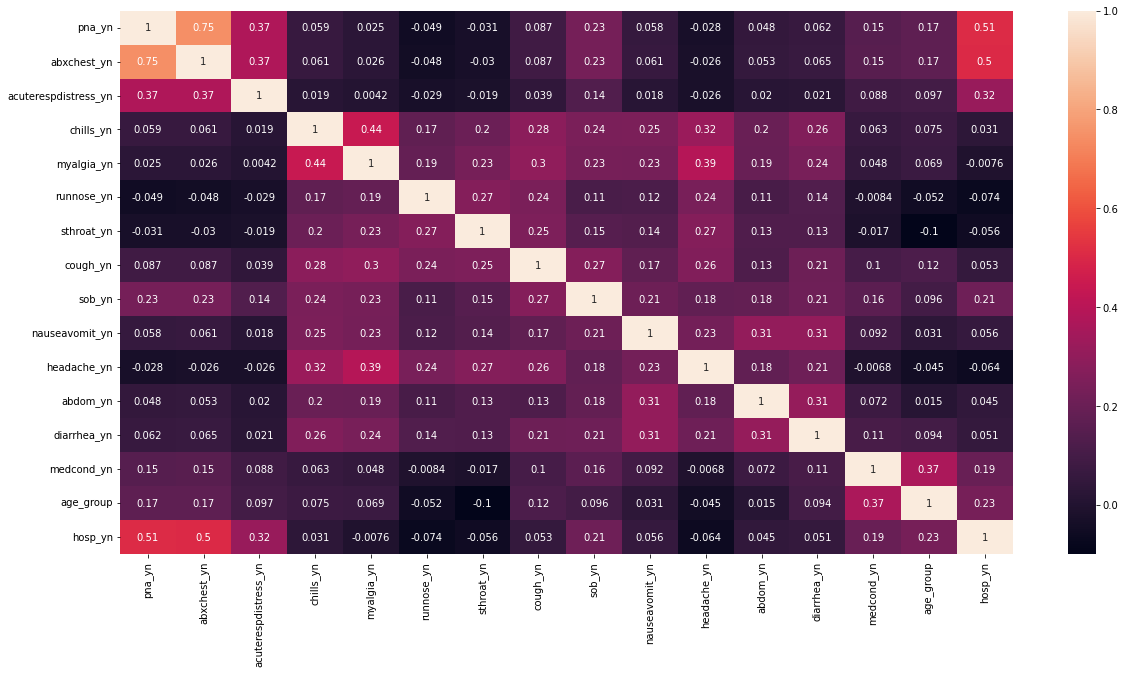

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
df = pd.read_csv('preprocessed_data.csv')
#dropping the index column
df = df.iloc[: , 1:]

#Correlation matrix:
fig1 = plt.figure(1)
fig1.set_size_inches(20,10)
sb.heatmap(df.corr(), annot= True)


No major multicollinearity in the dataset, only pneumonia and abnormal chest x-ray have 0.75 correlation with one another.


Age distribution in the dataset:

([<matplotlib.axis.XTick at 0x2a6acb56820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

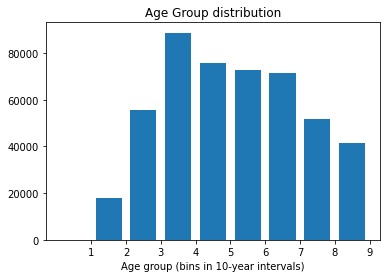

In [2]:
fig5 = plt.figure()
plt.title('Age Group distribution')
ax = plt.hist(df['age_group'], bins=np.arange((10)),rwidth=0.75)
plt.xlabel('Age group (bins in 10-year intervals)')
plt.xticks(range(1,10))

Visualisation with PCA:

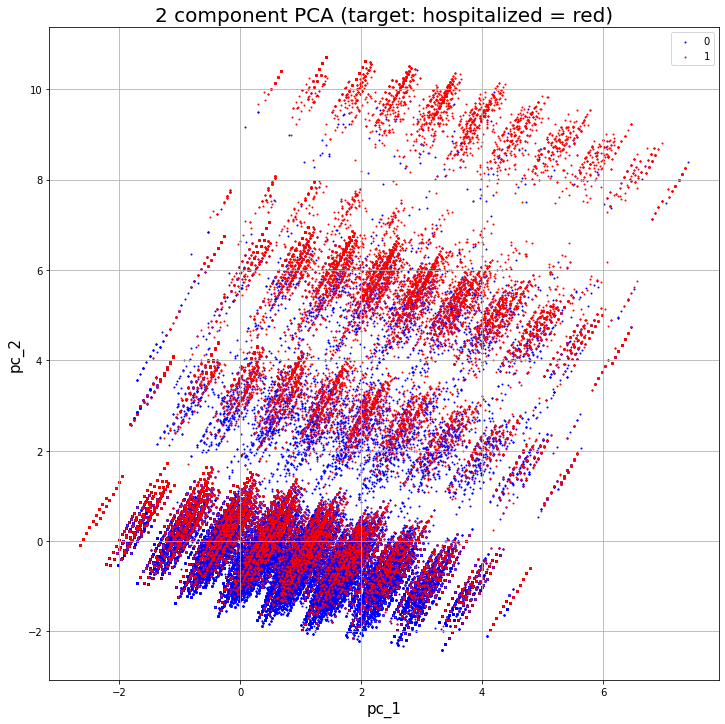

In [3]:
columns = [  
                        'pna_yn',
                        'abxchest_yn',
                        'acuterespdistress_yn',
                        'chills_yn',
                        'myalgia_yn',
                        'runnose_yn',
                        'sthroat_yn',
                        'cough_yn',
                        'sob_yn',
                        'nauseavomit_yn',
                        'headache_yn',
                        'abdom_yn',
                        'diarrhea_yn',
                        'medcond_yn',
                        'age_group'
]
x = df[columns]
y = df['hosp_yn']
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principaldf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2'])
finaldf = pd.concat([principaldf, y], axis = 1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc_1', fontsize = 15)
ax.set_ylabel('pc_2', fontsize = 15)
ax.set_title('2 component PCA (target: hospitalized = red)', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finaldf['hosp_yn'] == target
    ax.scatter(finaldf.loc[indicesToKeep, 'pc_1']
               , finaldf.loc[indicesToKeep, 'pc_2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()

Visualising data imbalance:

n_datapoints: 475290
n_hospitalized: 29812


Text(0.5, 0, 'Hospitalized (0: no, 1: yes)')

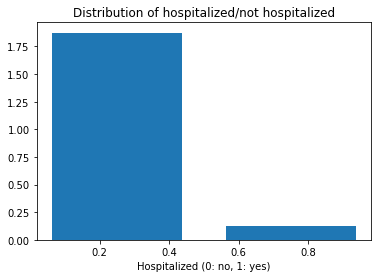

In [4]:
print('n_datapoints:',len(df.index))
print('n_hospitalized:',len(df[df['hosp_yn'] == 1].index))

fig6 = plt.figure()
plt.title('Distribution of hospitalized/not hospitalized')
ax = plt.hist(df['hosp_yn'],bins=2, rwidth=0.75,density=True)
plt.xlabel('Hospitalized (0: no, 1: yes)')

## Dealing with data imbalance: undersampling

Undersampling only makes the results worse...

In [5]:
#Splitting the data

features_all = df.drop(['hosp_yn'],1)
target_all = df['hosp_yn']

features_train, features_test, target_train, target_test = train_test_split(features_all, target_all, 
                                                    test_size = 0.2,
                                                    random_state = 2,
                                                    stratify = target_all)

# Standardization

scaler = StandardScaler()
#fit the scaler and transform the training set
features_train = scaler.fit_transform(features_train)

#transform the testing set with the same parameters used to transform the training set
features_test = scaler.transform(features_test)


''' Near miss undersampling algorithm implemented in the Imbalanced-learn library
#nm = imblearn.under_sampling.NearMiss(version=1)
#features_train, target_train = nm.fit_resample(features_train, target_train)

fig6 = plt.figure()
plt.title('Distribution after near miss undersampling (training set)')
ax = plt.hist(target_train,bins=2, rwidth=0.75,density=False)
plt.xlabel('Hospitalized (0: no, 1: yes)')
'''

C:\Users\Juho\AppData\Local\Temp/ipykernel_12056/973114146.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_all = df.drop(['hosp_yn'],1)


" Near miss undersampling algorithm implemented in the Imbalanced-learn library\n#nm = imblearn.under_sampling.NearMiss(version=1)\n#features_train, target_train = nm.fit_resample(features_train, target_train)\n\nfig6 = plt.figure()\nplt.title('Distribution after near miss undersampling (training set)')\nax = plt.hist(target_train,bins=2, rwidth=0.75,density=False)\nplt.xlabel('Hospitalized (0: no, 1: yes)')\n"

#### Logistic Regression:

Logistic Regression:
              precision    recall  f1-score   support

           0     0.9598    0.9924    0.9758     89096
           1     0.7698    0.3781    0.5071      5962

    accuracy                         0.9539     95058
   macro avg     0.8648    0.6852    0.7415     95058
weighted avg     0.9478    0.9539    0.9464     95058

Index(['pna_yn', 'abxchest_yn', 'acuterespdistress_yn', 'chills_yn',
       'myalgia_yn', 'runnose_yn', 'sthroat_yn', 'cough_yn', 'sob_yn',
       'nauseavomit_yn', 'headache_yn', 'abdom_yn', 'diarrhea_yn',
       'medcond_yn', 'age_group'],
      dtype='object')
logistic regression feature weights:
[[ 0.31563506  0.31284857  0.12305752  0.08274817 -0.07940118 -0.27378042
  -0.1236367  -0.09671626  0.44026245  0.09387491 -0.19395069  0.10690336
  -0.02968889  0.39965639  0.73141558]]


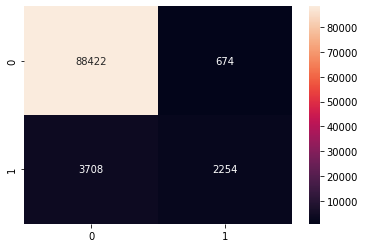

In [10]:

classifier = SGDClassifier(loss='log' ,max_iter=1000, tol=1e-3)

classifier.fit(features_train,target_train)

predicted = classifier.predict(features_test)

cm = confusion_matrix(target_test, predicted)

fig2 = plt.figure(2)
sb.heatmap(cm, annot=True,fmt='d')

print("Logistic Regression:")
print(classification_report(target_test, predicted,digits=4))


print(features_all.columns)
print("logistic regression feature weights:")
print(classifier.coef_)

#### 10-fold Cross validation for logistic regression:

In [7]:
scores = cross_val_score(classifier, features_train, target_train, cv=10, scoring='f1')
print('The mean and variance of F_1 score in 10-fold CV:')
print("F_1 score: %0.3f, variance %0.5f" % (scores.mean(), scores.std() * 2))

The mean and variance of F_1 score in 10-fold CV:
F_1 score: 0.504, variance 0.05112


#### 2. SVM:

Support vector machines:
              precision    recall  f1-score   support

           0     0.9624    0.9863    0.9742     89096
           1     0.6752    0.4247    0.5214      5962

    accuracy                         0.9511     95058
   macro avg     0.8188    0.7055    0.7478     95058
weighted avg     0.9444    0.9511    0.9458     95058



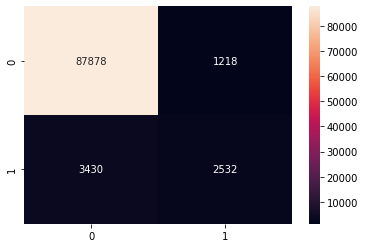

In [8]:

classifier = SGDClassifier(loss='hinge' ,max_iter=1000, tol=1e-3)

classifier.fit(features_train,target_train)

predicted = classifier.predict(features_test)

cm = confusion_matrix(target_test, predicted)

fig3 = plt.figure(3)
sb.heatmap(cm, annot=True,fmt='d')
print("Support vector machines:")
print(classification_report(target_test, predicted,digits=4))

#### 10-fold CV for SVM classifier:

In [9]:
scores = cross_val_score(classifier, features_train, target_train, cv=10, scoring='f1')
print('The mean and variance of F_1 score in 10-fold CV:')
print("F_1 score: %0.3f, variance %0.5f" % (scores.mean(), scores.std() * 2))

The mean and variance of F_1 score in 10-fold CV:
F_1 score: 0.523, variance 0.02473


#### 3. XGBoost

Gradient Boosting:
              precision    recall  f1-score   support

           0     0.9618    0.9907    0.9760     89096
           1     0.7465    0.4114    0.5305      5962

    accuracy                         0.9543     95058
   macro avg     0.8541    0.7010    0.7532     95058
weighted avg     0.9483    0.9543    0.9481     95058



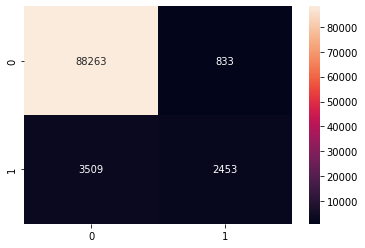

In [10]:

classifier = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='logloss',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

classifier.fit(features_train,target_train)

predicted = classifier.predict(features_test)

cm = confusion_matrix(target_test, predicted)

fig4 = plt.figure(4)
sb.heatmap(cm, annot=True,fmt='d')
print("Gradient Boosting:")
print(classification_report(target_test, predicted,digits=4))

#### 10-fold CV for XGBoost:

In [11]:
scores = cross_val_score(classifier, features_train, target_train, cv=10, scoring='f1')
print('The mean and variance of F_1 score in 10-fold CV:')
print("F_1 score: %0.3f, variance %0.5f" % (scores.mean(), scores.std() * 2))

The mean and variance of F_1 score in 10-fold CV:
F_1 score: 0.532, variance 0.01405


#### Parameter tuning for XGboost:

In [12]:
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4],
              'max_depth': [6,7,8,9,10,11,12,13],
              'n_estimators': [50,65,80,100,115,130],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'scale_pos_weight':[1,2,3,4,5,6]}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

clf = BayesSearchCV(estimator=classifier, search_spaces=param_grid, n_iter=int(gcvj), scoring='f1', cv=3, return_train_score=True, verbose=3)
clf.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=6.4, learning_rate=0.25, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=6.4, scale_pos_weight=2;, score=(train=0.571, test=0.566) total time=   0.6s
[CV 2/3] END gamma=6.4, learning_rate=0.25, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=6.4, scale_pos_weight=2;, score=(train=0.573, test=0.565) total time=   0.6s
[CV 3/3] END gamma=6.4, learning_rate=0.25, max_depth=6, n_estimators=80, reg_alpha=12.8, reg_lambda=6.4, scale_pos_weight=2;, score=(train=0.571, test=0.571) total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=12.8, learning_rate=0.3, max_depth=10, n_estimators=50, reg_alpha=102.4, reg_lambda=3.2, scale_pos_weight=4;, score=(train=0.564, test=0.565) total time=   0.4s
[CV 2/3] END gamma=12.8, learning_rate=0.3, max_depth=10, n_estimators=50, reg_alpha=102.4, reg_lambda=3.2, scale_pos_weight=4;, score=(train=0.567, test=0.562) total t

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1, eval_metric='logloss',
                                      gamma=0, gpu_id=-1,
                                      grow_policy='lossguide',
                                      importance_type='gain',
                                      interaction_constraints='',
                                      learning_rate=0.300000012,
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constrai...
              search_spaces={'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4,
                                       12.8, 25.6, 51.2, 102.4, 200],
                             'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2,
       

Best F_1-score in optimization:  0.5716821331432825
Gradient Boosting, optimized (training):
              precision    recall  f1-score   support

           0     0.9698    0.9769    0.9734    356382
           1     0.6130    0.5456    0.5773     23850

    accuracy                         0.9499    380232
   macro avg     0.7914    0.7613    0.7753    380232
weighted avg     0.9474    0.9499    0.9485    380232



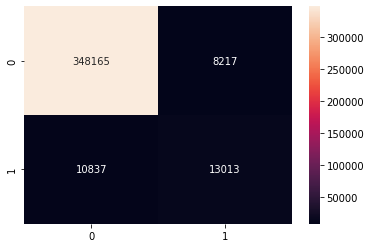

In [17]:
print("Best F_1-score in optimization: ",clf.best_score_ )

predicted = clf.predict(features_train)

cm = confusion_matrix(target_train, predicted)

fig4 = plt.figure(6)
sb.heatmap(cm, annot=True,fmt='d')
print("Gradient Boosting, optimized (training):")
print(classification_report(target_train, predicted,digits=4))

Gradient Boosting, optimized (test):
              precision    recall  f1-score   support

           0     0.9694    0.9774    0.9734     89096
           1     0.6145    0.5392    0.5744      5962

    accuracy                         0.9499     95058
   macro avg     0.7920    0.7583    0.7739     95058
weighted avg     0.9472    0.9499    0.9484     95058



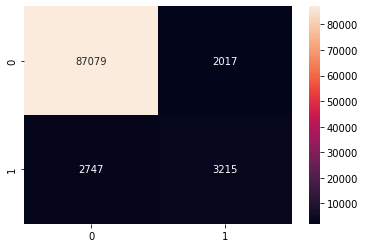

In [15]:
predicted = clf.predict(features_test)

cm = confusion_matrix(target_test, predicted)

fig5 = plt.figure(7)
sb.heatmap(cm, annot=True,fmt='d')
print("Gradient Boosting, optimized (test):")
print(classification_report(target_test, predicted,digits=4))